# Quantifying Gerrymandering in North Carolina

### Collaborators

Aditya Karan, Manish Reddy Vuyyuru, Zizheng Xu

In [46]:
import mcmc_code, os
from gerrychain import Graph, Partition
from gerrychain.updaters import Tally, county_splits, boundary_nodes, cut_edges, cut_edges_by_part, exterior_boundaries, interior_boundaries, perimeter
import os

from gerrychain import MarkovChain
#importlib.reload(gerrychain.MarkovChain)

from gerrychain.constraints import single_flip_contiguous, districts_within_tolerance
from gerrychain.proposals import propose_random_flip
import gerrychain.scores
from gerrychain import Election
from gerrychain.constraints.validity import deviation_from_ideal
from gerrychain.accept import always_accept

import importlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
importlib.reload(mcmc_code)




<module 'mcmc_code' from 'C:\\Users\\Aditya\\Documents\\HW\\AM207\\Project\\mcmc_code.py'>

In politics, [Gerrymandering](https://en.wikipedia.org/wiki/Gerrymandering)  is the practice of intentionally manipulating voting districts in a given region to favor a given party. Often this results in relatively [outlandish shapes of voting districts](https://www.washingtonpost.com/news/wonk/wp/2014/05/15/americas-most-gerrymandered-congressional-districts/?noredirect=on&utm_term=.b80135dfefec). However, the practice remains widespread. In particular, the courts haven't addressed whether one could go to far in explict partisn gerrymandering. The question has often come down to measurabilty - in 2004, Justice Kennedy wrote in his opinion [VIETH V. JUBELIRER](https://www.law.cornell.edu/supct/html/02-1580.ZC.html), states that while the court declained to intervene in this particular map "	the failings of the many proposed standards for measuring the burden a gerrymander imposes on representational rights make our intervention improper.	If workable standards do emerge to measure these burdens, however, courts should be prepared to order relief."

Several measures of partisin gerrymandering have arisen since that time. However, quantifying how much a certian map is biased one way or another alone cannot demosntrate gerrymandering - because of our desire for compactness of districts, keeping relevant natural communites as in the same district and complince of the Voting Rights Act, just scoring a map can't address the problem. 

Luckily there is a solution that can help! If we were able to sample a set of reasonable maps, we can quantify over the possible sets of reasonable graphs - what are the expected numbers of wins etc across this ensamble. Hence Markov Chain Monte Carlo provides a opportunity for us to generate these samples of maps. Once we have a sample we can compute these various statisics and compare to the actual maps to come up with a way of telling whether a given map's statistics would come up by chance or is there a concerted effort to gerrymander. 

We will leverage the GerryChain python package to help organize our data and learn how to start sampling the set of all maps



To start - we've provided data shapefiles/geojson files to aide. These are a best effort means of reconcilling precient level election data and population data - needed to help sample.


The two main objects we'll be concerned about are "Graph" objects and "Partition" objects. Graph objects can be geenrate by the Geojson/Shapefiles and give us back a networkx like graph - where the nodes are analogus to precients and the edges represnt two precients being geographically adjacent. 

A partition is a split of the graph into $n$ number of parts. Here we want to partition into $13$ districts. 


In [2]:
filepath = os.path.join("old_new_NC")
graph = mcmc_code.generate_graph(filepath)
# Manual Bugfix - don't worry about it
graph.nodes[2293]['2014_CD'] = 2
graph.nodes[2349]['2014_CD']  = 4


C:\Users\Aditya\Anaconda3\envs\gdaltest2\lib\site-packages\gerrychain\graph\adjacency.py:68: UserWarning: Found overlaps among the given polygons. Indices of overlaps: {(298, 299), (2262, 2263), (2390, 2391), (2486, 2487), (676, 677), (1436, 1437), (2301, 2302), (2646, 2647), (2742, 2743), (1576, 1577), (1118, 1119), (302, 303), (722, 723), (990, 991), (994, 995), (1198, 1199), (1438, 1439), (2258, 2259), (2578, 2579), (544, 545), (300, 301), (1108, 1109), (2260, 2261), (2740, 2741), (1016, 1017), (2585, 2586), (2723, 2724), (165, 166), (293, 294), (644, 645), (1020, 1021), (1028, 1029), (2729, 2730), (681, 682), (1257, 1258), (1022, 1023), (1026, 1027), (1394, 1395), (683, 684), (2475, 2476), (640, 641), (657, 658), (1013, 1014), (1205, 1206), (2477, 2478), (835, 836), (1039, 1040), (2678, 2679), (1034, 1035), (1418, 1419), (2538, 2539), (1032, 1033), (1087, 1088), (838, 839), (2299, 2300), (2746, 2747), (1420, 1421), (1428, 1429), (2676, 2677), (1241, 1242), (2649, 2650), (2744, 2745

And for the partition - we'll split first by the default and plot to get a look

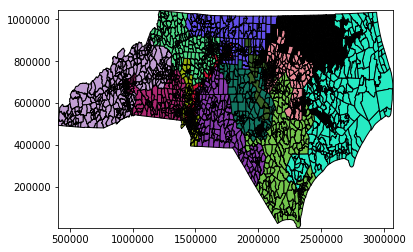

In [3]:
#This will let us keep track of elections in different partitions!

election = Election(
        "2014 Senate", 
        {"Democratic": "sen_blue", "Republican": "sen_red"},
        alias="2014_Senate"
    )


sample_partition = Partition(
            graph,
            assignment="2014_CD", #Actual congressional district partition from the initial dataset
            updaters={
                "2014_Senate": election,
            }

)
mcmc_code.plot_state(sample_partition) 

We can already see these shapes are a bit funky, but how funky are the actual outcomes?

Now to run a simple GerryChain example - we can set up a Markov Chain (explain a bit on how to do it and then demo the simpliest chain we can do ). Here, in particular, our "step" in our markov chain is labeled here as "single_flip". Here, we look at the edges in which the nodes are part of two different districts. Out of all those edges, we pick one and then with $\frac{1}{2}$ flip the node to the other district. 



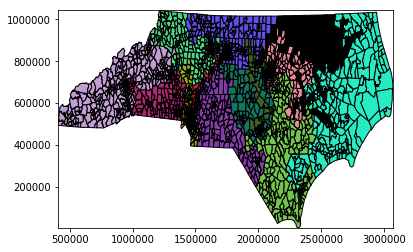

In [4]:
num_samples = 100
chain = MarkovChain(
        proposal=propose_random_flip,# Does the node flip based on conflicted edges as describe above 
        is_valid=single_flip_contiguous, # A function that alwaysd returns true
        accept=always_accept, # A function that also always returns true
        initial_state=sample_partition, # Start with partition above 
        total_steps= num_samples,
)

simple_part = []
wins = []
for partition in chain:
    # The below is to check whether a given partition has been accepted
    # In this case it's always accepted so always true
    if(hasattr(partition, 'accepted') and partition.accepted):
        wins.append(partition["2014_Senate"].wins("Democratic"))
        simple_part.append(partition)

mcmc_code.plot_state(simple_part[-1]) 

Congrats - you just run your first chain!!

But something seems odd. Are there any constraints? Aren't there some districts that we would prefer to others? Do we really want to choose all districts? 

Good observation! Some districts are "better" than others in some sense, and we want to take that in consideration. 

In MCMC language, we consider all possible maps to be sampled from some probablity distribution. We would like to consider the probablity distribution of "reasonable maps" as the probablity distribution we're pulling from. 

To do this  - we'll implement a Metropolis-Hasting criteria and build up our sampling function based on our idea of a "good" map

`

FROM HERE - BREAK DOWN THE SCORING FUNCTION SIMILAR TO WHATS BELOW BUT WITH CODE FOR EACH ONE. Summary below is good  - then breaking each one down

We don't have to show all the nitty gritty code - put most of it in a library and only demo the ones that are relatively interesting. 

The format woudl roughly be text explaining scoring fucntion - implematnion of a part and perhaps a demo of what the score will be 


After that - introduce the idea of weights then the annealing parameter 

Unforunatley the Gerrychain MarkovChain class doesn't allow for annealing - so we have created a new class MarkovChainAnnealing - to allow for the simulating annealing (the change is pretty small and can be viewed in the supporting files for more information)

After that can be like "let's now try sampling" -> Generate samples with the constraints (can add constraints explanation as well ). 

Plot a few of the samples (can just randomly return some in the chain)

Then also talk about the statistics (efficiency gap/number of wins)

Plot the data of the sample + where the actual district score with some discussion

In [5]:
num_samples = 20000 # Change to 80k once done testing
(efficiency_gap, wins, win_percents, part ) = mcmc_code.run_simple(graph, num_samples = num_samples)



It took 2 time to get 1000 samples
It took 3 time to get 1000 samples
It took 3 time to get 1000 samples
It took 3 time to get 1000 samples
It took 3 time to get 1000 samples
It took 3 time to get 1000 samples
It took 3 time to get 1000 samples
It took 3 time to get 1000 samples
It took 3 time to get 1000 samples
It took 3 time to get 1000 samples
It took 3 time to get 1000 samples
It took 3 time to get 1000 samples
It took 3 time to get 1000 samples
It took 3 time to get 1000 samples
It took 3 time to get 1000 samples
It took 3 time to get 1000 samples
It took 3 time to get 1000 samples
It took 3 time to get 1000 samples
It took 3 time to get 1000 samples
It took 3 time to get 1000 samples
It took 3 time to get 1000 samples
It took 3 time to get 1000 samples
It took 3 time to get 1000 samples
It took 3 time to get 1000 samples
It took 3 time to get 1000 samples
It took 3 time to get 1000 samples
It took 3 time to get 1000 samples
It took 3 time to get 1000 samples
It took 3 time to ge

Phew that took a while...but now we have all our samples. 


Let's take a look!



In [ ]:
for p in part:
    mcmc_code.plot_state(p) 

In addition to the number of wins and efficiency gap - we compute two other metrics. 

The rep_index performs a basic regression to see at what the interpolated number of wins 

One thing we will do off the bat is to "burn" the first 10-20k of our samples. Since we've picked a very specific starting partition - we want to read only really look at the egrodotic part of the distribution - hence the burn factor. 

Lets burn and see our results!

In [ ]:
burn = 1000

In [6]:
def rep_index(win_percents):
    a = np.array(win_percents)
    a.sort()
    least_rep = 1 - a[np.argmax(a > 0.5)]
    least_dem = a[np.argmin(a < 0.5) + 1]
    num_win = len(a) - np.argmax(a > 0.5)
    delta = (50 - (100 - least_dem ))/(least_rep - (100 - least_dem))
    score = num_win + delta
    return(score)

def gerrymandering_index(average_sample, each_sample):
    a = np.array(average_sample)
    b = np.array(each_sample)
    a.sort()
    b.sort()
    return(np.linalg.norm(a - b))

def avg_sample(win_percents_arr):
    order = {}
    for i in range(1, 1 + len(win_percents_arr[0])):
        order[i] = 0
    for j in range(len(win_percents_arr)):
        elem = list(win_percents_arr[j])
        elem.sort()
        for s in range(len(elem)):
            order[s + 1] += elem[s]
    for i in range(1, 1 + len(win_percents_arr[0])):
        order[i] *= 1/len(win_percents_arr)
    fin = list(order.values())
    fin.sort(reverse = True)
    return(fin)



In [7]:
gerry_val = []
rep_val = []
avg = avg_sample(win_percents[:burn])
for elem in win_percents:
    rep_val.append(rep_index(elem))
    gerry_val.append(gerrymandering_index(avg, elem))

In [8]:
'''Get our initial statistics also'''
init_percents = sample_partition["2014_Senate"].percents("Democratic")
init_wins = sample_partition["2014_Senate"].wins("Democratic")
init_efficiency =(gerrychain.scores.efficiency_gap(sample_partition["2014_Senate"]))
init_rep_val = rep_index(init_percents)
init_gerry_val = gerrymandering_index(avg, init_percents)

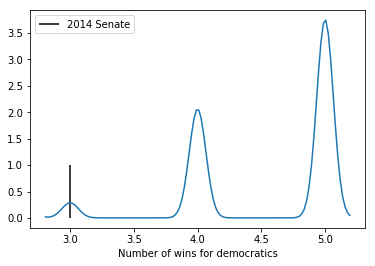

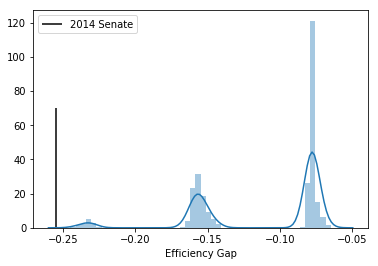

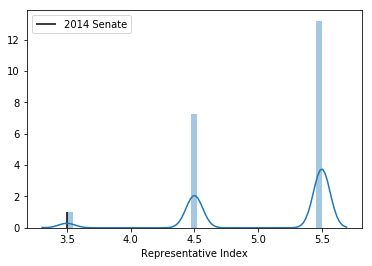

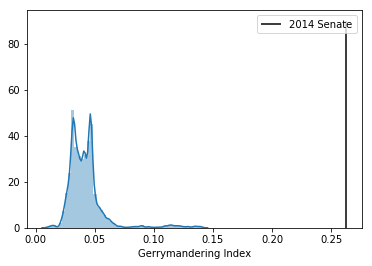

In [31]:
sns.kdeplot(wins[burn:])
plt.vlines(init_wins, 0, 1, label = '2014 Senate')
plt.xlabel('Number of wins for democratics')
plt.legend()
plt.show()

sns.distplot(efficiency_gap[burn:])
plt.vlines(init_efficiency, 0, 70, label = '2014 Senate')
plt.xlabel('Efficiency Gap')
plt.legend()
plt.show()

sns.distplot(rep_val[burn:])
plt.vlines(init_rep_val,0, 1, label = '2014 Senate')
plt.xlabel('Representative Index')
plt.legend()
plt.show()

sns.distplot(gerry_val[burn:])
plt.vlines(init_gerry_val, 0, 90, label = '2014 Senate')
plt.xlabel('Gerrymandering Index')
plt.legend()
plt.show()

We expect to see that in this sampling, the 2014 map prodcues measures such as efficiency gap, representtive index and gerrymandering value extremely skewed towards the distribution. If it's extremely skewed - we believe therefore, that it is highly unlikely that this map was "pulled" randomly from the distribution on all reasonable maps. This suggests that there is some partisin factor in creating this gap 

In [32]:
lb = 0.5
ub = 99.5
interval = ub - lb
print("99 credible interval #wins is (%f, %f)" % (np.percentile(wins[burn:], 0.5), np.percentile(wins[burn:], 99.5)))

print("99 credible interval #eff_gap is (%f, %f)" % (np.percentile(efficiency_gap[burn:], 0.5), np.percentile(efficiency_gap[burn:], 99.5)))
print("99 credible interval #rep_val is (%f, %f)" % (np.percentile(rep_val[burn:], 0.5), np.percentile(rep_val[burn:], 99.5)))
print("99 credible interval #gerry_val is (%f, %f)" % (np.percentile(gerry_val[burn:], 0.5), np.percentile(gerry_val[burn:], 99.5)))


print("2014 Senate Wins is %f" % init_wins)
print("2014 Senate eff gap is %f" % init_efficiency)
print("2014 Senate rep val is %f" % init_rep_val)
print("2014 Senate gerry valis %f" % init_gerry_val)



99 credible interval #wins is (3.000000, 5.000000)
99 credible interval #eff_gap is (-0.239154, -0.068235)
99 credible interval #rep_val is (3.498626, 5.499936)
99 credible interval #gerry_val is (0.015575, 0.132983)
2014 Senate Wins is 3.000000
2014 Senate eff gap is -0.255192
2014 Senate rep val is 3.498026
2014 Senate gerry valis 0.263029


# Objective

Using resampling tests to determine whether or not a specific districting plans has a suspition of being gerrymandered. The process of resampling from the space of valid redistriction plans is carried out by MCMC methods.

# Approach

Our general procedures of this test include:

(i) sample from all the possibilities of congressional redistricting plans (a.k.a. space of congressional redistricting plans) that adheres to non-partisan redistricting criteria. The way to generate the next sample of redistricting plan given the current one  will be elaborated in **Implementation** section.  

(ii) For each of our sampled redistricting plan, simulate an election result. Aggregate election results to construct the distributions of partisan vote balance on each district and of the congressional delegation’s partisan composition. This distribution is deemed free from any gerrymandering because it is a representive sample of all possible redistrictings.

(iii) check whether the congressional delegation’s partisan composition is commonly seen in the aggregated distribution. When a districting is gerrymandered, it will deviate from the mode of the distribution, end up having extreme values on one of the tails of the distribution.  

# Data 

Voting Tabulation Districts (VTD) geographic data was taken from the NCGA website. [Legislature NC (2010) 2010 VTD geographic data](http://www.ncleg.net/representation/Content/BaseData/BD2016.aspx)







# Implementation


## Mathematics notations

To define the score function, we introduce several mathematical formalisms, the first of which is represents the
state of North Carolina as a graph $ G$ with edges $E$ and vertices $V$ . Each vertex represents a Voting Tabulation District (VTD); an edge between
two vertices exists if the two VTDs share boundaries with non-zero length. In general VTDs may be split into census blocks, however (i)
the utilized redistricting criteria requires this splitting to minimized and (ii) we demonstrate that splitting VTDs to achieve zero population
deviation in a district has nearly no effect on our results.

Defining the graph this way allows us to formally define a redistricting plan: Assuming each VTD belongs to a single district, a redistricting
plan is defined as a function from the vertices, $V$ , to one of the possible districts, which are represented by sequential integers – there are
thirteen congressional districts in North Carolina, so we define a redistricting plan as a function
$\xi : V \rightarrow \{ 1,2 , \dots , 13 \}$.

The redistricting plan
function ξ is interpreted as follows: If a VTD is represented by a vertex $v \in V ,$ then $\xi ( v ) = i$ means that the VTD in question belongs to
district $i$; similarly, for any $i \in \{ 1,2 , \dots , 13 \}$ and plan $\xi ,$ the $i -$ th  district, denoted $D _ { i } ( \xi ) ,$ is given by the set $\{ v \in V : \xi ( v ) = i \}$. 

We restrict
the space of considered redistricting plans $\xi$ such that each district $D _ { i } ( \xi )$ is a single connected component; this restriction, along with our edge criteria, ensures that districts must be contiguous.
We denote the collection of all redistricting plans with connected districts by  $\mathcal { R }$


## MCMC sampling overview

Using a MCMC method to sample possible redistriction plans requires one to generate the next valid redistricting plans given the current one. This requires us to define a probability distribution on the space of redistricting plans. The probability is derived from **score functions**.

## score function
We define this family of distributions based on a score function that evaluates the overall “goodness” of a districting plan. 

The non-partisan design criteria of state law requires every redistricting that:

1. the state population is evenly divided between the thirteen congressional districts,

2. the districts are connected and compact,

3. splitting counties is minimized, and

4. African-American voters are sufficiently concentrated in two districts to affect the winner.

The first three criteria come from House Bill 92 (HB92) of the NC General Assembly


A plan ξ is rated with our score function denoted J. J maps each redistricting ξ ∈ R to a nonnegative number. Lower scores signify redistricting plans that more closely adhere to the criteria of HB92. We break down the score function J into four components that
measure how well a given redistricting satisfies the individual principles outlined in HB92:

1. the population score $J _ { p } ( \xi )$ : measures how well the redistricting ξ partitions the population of North Carolina into 13 equal population
groups; 

2. the isoperimetric score  $J _ { I } ( \xi ) $: measures how compact the districts are; 

3. the county score $J _ { c } ( \xi )$: measures the number of counties split between multiple districts; 

4. the minority score  $J _ { m } ( \xi )$ measures the extent to which a districting plan adheres to the VRA

Then our score function $J$ is defined as a weighted sum of $J _ { p } , J _ { I } , J _ { c } ,$ and $J _ { m }$

$J ( \xi ) = w _ { p } J _ { p } ( \xi ) + w _ { I } J _ { I } ( \xi ) + w _ { c } J _ { c } ( \xi ) + w _ { m } J _ { m } ( \xi )$

where $w _ { p } , w _ { I } , w _ { c } ,$ and $w _ { m }$ are a collection of positive weights determined by an iterative process.


### The population score function  $J _ { p } ( \xi )$
The population score, which measures how evenly populated the districts are, is defined by

$$J _ { p } ( \xi ) = \sqrt { \sum _ { i = 1 } ^ { 13 } \left( \frac { \operatorname { pop } \left( D _ { i } ( \xi ) \right) } { \text { pop}_{\text {ldeal}}  } - 1 \right) ^ { 2 } }, \ \mathrm { pop } _ { \text {ldeal} } = \frac { N _ { \text {pop} } } { 13 }$$

where $N _ {$pop$}$ is the total population of North Carolina, pop$\left( D _ { i } ( \xi ) \right)$ is the population of the district $D _ { i } ( \xi )$.


### The Isoparametric score function  $J _ { I } ( \xi ) $

The Isoperimetric score, which measures the overall compactness of a redistricting, is defined by

$$J _ { I } ( \xi ) = \sum _ { i = 1 } ^ { 13 } \frac { \left[ \mathrm { boundary } \left( \partial D _ { i } ( \xi ) \right) \right] ^ { 2 } } { \operatorname { area } \left( D _ { i } ( \xi ) \right) }$$

It is is the ratio of the square perimeter to the total area of each district. The Isoparametric score is minimized for a circle, which is the most
compact shape.

### The county score function $J _ { c } ( \xi )$

### The Voting Rights Act or minority score function $J _ { m } ( \xi )$

## probability distribution
Then use the score function to
define a **probability distribution**. 


The acceptance probability is
given by:


Data Source: We took the 2014 election data shapefile from http://mike.teczno.com/notes/redistricting/building-north-carolina-data.html

We then fixed up the shapefile geometries with Shapefiles provided by the North Carolina State board for 2014 Precients https://dl.ncsbe.gov/

We tried to also layer on 2016 precient data for comparision using the same precient files/ 2016 Congressional maps - but the resulting distribution of the population was not reasonable. Hence the 2016_NC column should be ignored